In [1]:
%matplotlib inline

In [2]:
### M*-based mock###
from astropy.table import Table
fname = '/Users/aphearin/Dropbox/published_age_matching/published_age_matching.hdf5'
age_matching = Table.read(fname, path='data')
age_matching['hostid'] = age_matching['upid']
cenmask = age_matching['upid'] == -1
age_matching['hostid'][cenmask] = age_matching['id'][cenmask]

cens = age_matching[cenmask]
sats = age_matching[~cenmask] 

qmask = age_matching['ssfr'] < -11
quenched = age_matching[qmask]
active = age_matching[~qmask]

In [3]:
from halotools.mock_observables import tpcf_one_two_halo_decomp, tpcf
from halotools.mock_observables import return_xyz_formatted_array

pos_all_3d = return_xyz_formatted_array(age_matching['x'], age_matching['y'], age_matching['z'])
logrbins = np.linspace(-2., 1.35, 40)
logrmids = 0.5*(logrbins[:-1] + logrbins[1:])
rbins, rmids = 10**logrbins, 10**logrmids
xi_1h, xi_2h = tpcf_one_two_halo_decomp(pos_all_3d, age_matching['hostid'], rbins, period=250.)
xi_all = tpcf(pos_all_3d, rbins, period=250.)

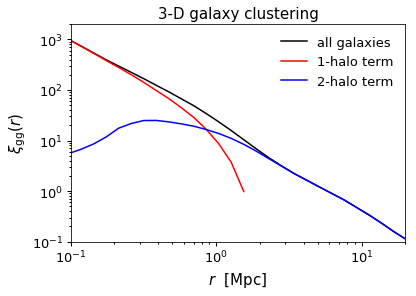

In [4]:
fig, ax = plt.subplots(1, 1)

ax.loglog()

__=ax.plot(rmids, xi_all, color='k', label='all galaxies')
__=ax.plot(rmids, xi_1h, color='red', label='1-halo term')
__=ax.plot(rmids, xi_2h, color='blue', label='2-halo term')

xlim = ax.set_xlim(1e-1, 20)
ylim = ax.set_ylim(0.1, 2000)
legend = ax.legend()

xlabel = ax.set_xlabel(r'$r$  $[{\rm Mpc}]$')
ylabel = ax.set_ylabel(r'$\xi_{\rm gg}(r)$')
title = ax.set_title('3-D galaxy clustering')

fig.savefig('FIGS/tpcf_galaxies.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


In [5]:
from halotools.mock_observables import wp

pi_max = 20.
logrp_bins = np.linspace(-2., 1.35, 40)
logrp_mids = 0.5*(logrp_bins[:-1] + logrp_bins[1:])
rp_bins, rp_mids = 10**logrp_bins, 10**logrp_mids


pos_all_zspace = return_xyz_formatted_array(age_matching['x'], age_matching['y'], age_matching['z'], 
                                  velocity=age_matching['vz'], velocity_distortion_dimension='z', period=250.)

pos_q_zspace = return_xyz_formatted_array(quenched['x'], quenched['y'], quenched['z'], 
                                  velocity=quenched['vz'], velocity_distortion_dimension='z', period=250.)
pos_a_zspace = return_xyz_formatted_array(active['x'], active['y'], active['z'], 
                                  velocity=active['vz'], velocity_distortion_dimension='z', period=250.)

wp_all = wp(pos_all_zspace, rp_bins, pi_max, period=250.)
wp_q, wp_qa, wp_a = wp(pos_q_zspace, rp_bins, pi_max, period=250., sample2=pos_a_zspace, do_auto=True, do_cross=True)


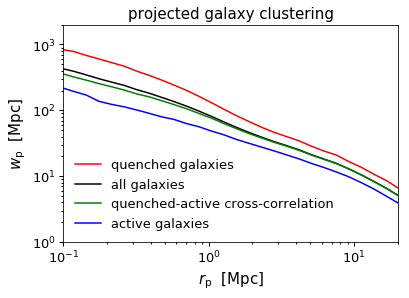

In [6]:
fig, ax = plt.subplots(1, 1)

ax.loglog()

__=ax.plot(rp_mids, wp_q, color='red', label='quenched galaxies')
__=ax.plot(rp_mids, wp_all, color='k', label='all galaxies')
__=ax.plot(rp_mids, wp_qa, color='green', label='quenched-active cross-correlation')
__=ax.plot(rp_mids, wp_a, color='blue', label='active galaxies')

xlim = ax.set_xlim(1e-1, 20)
ylim = ax.set_ylim(1, 2000)
legend = ax.legend()

xlabel = ax.set_xlabel(r'$r_{\rm p}$  $[{\rm Mpc}]$')
ylabel = ax.set_ylabel(r'$w_{\rm p}$  $[{\rm Mpc}]$')
title = ax.set_title('projected galaxy clustering')

fig.savefig('FIGS/wp_galaxies.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


In [7]:
from halotools.mock_observables import delta_sigma

In [8]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', redshift=0)
pos_ptcls = return_xyz_formatted_array(halocat.ptcl_table['x'], 
                                       halocat.ptcl_table['y'], halocat.ptcl_table['z'])
total_num_ptcl_in_snapshot = halocat.num_ptcl_per_dim**3
downsampling_factor = total_num_ptcl_in_snapshot/float(len(pos_ptcls))

mask = (age_matching['mpeak'] > 10**13.75)
pos_bcg = return_xyz_formatted_array(age_matching['x'], age_matching['y'], age_matching['z'], 
                                    mask=mask)
mask = (age_matching['mpeak'] > 10**13.25) & (age_matching['mpeak'] < 10**13.75)
pos_grp = return_xyz_formatted_array(age_matching['x'], age_matching['y'], age_matching['z'], 
                                    mask=mask)

rp_mids, ds_bcg = delta_sigma(pos_bcg, pos_ptcls, 
                          halocat.particle_mass, downsampling_factor, 
                          rp_bins, period=halocat.Lbox)
rp_mids, ds_grp = delta_sigma(pos_grp, pos_ptcls, 
                          halocat.particle_mass, downsampling_factor, 
                          rp_bins, period=halocat.Lbox)

unit_conversion_factor = 1e12
ds_bcg /= unit_conversion_factor
ds_grp /= unit_conversion_factor

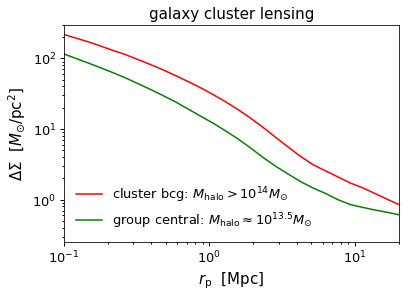

In [9]:
from scipy.signal import savgol_filter

fig, ax = plt.subplots(1, 1)
ax.loglog()

__=ax.plot(rp_mids, savgol_filter(ds_bcg, 7, 3), 
           color='red', label=r'cluster bcg: $M_{\rm halo}>10^{14}M_{\odot}$')
__=ax.plot(rp_mids, savgol_filter(ds_grp, 7, 3), 
           color='green', label=r'group central: $M_{\rm halo}\approx10^{13.5}M_{\odot}$')

xlim = ax.set_xlim(0.1, 20)
ylim = ax.set_ylim(0.25, 300)

xlabel = ax.set_xlabel(r'$r_{\rm p}$  $[{\rm Mpc}]$')
ylabel = ax.set_ylabel(r'$\Delta\Sigma$  $[M_{\odot}/{\rm pc}^2]$')
title = ax.set_title('galaxy cluster lensing')
legend = ax.legend()
fig.savefig('FIGS/galaxy_cluster_lensing.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


In [10]:
from umachine_pyio.load_mock import load_mock_from_binaries, value_added_mock
subvolumes = np.arange(144)
galprops = list(('upid', 'obs_sfr', 'icl', 'mpeak', 'sfr', 
                  'halo_id', 'mvir', 'rvir', 'vx', 'sm', 'vy', 'y', 'x', 
                  'z', 'vz', 'obs_sm'))
um_mock = value_added_mock(load_mock_from_binaries(subvolumes, galprops=galprops), 250.)
um_mock['ssfr'] = np.log10(um_mock['obs_sfr']/um_mock['obs_sm'])

Total runtime = 34.37 seconds


In [11]:
from halotools.mock_observables import conditional_cylindrical_isolation

marks1 = np.log10(um_mock['sm'])
marks2 = np.log10(um_mock['sm'])
cond_func = 2

rp_max, pi_max = 0.25, 5.

um_pos = return_xyz_formatted_array(um_mock['x'], um_mock['y'], um_mock['z'], velocity=um_mock['vz'], 
                                   velocity_distortion_dimension='z', period=250.)

is_iso_all = conditional_cylindrical_isolation(um_pos, um_pos, rp_max, pi_max, 
                                 marks1, marks2, cond_func=2, period=250)


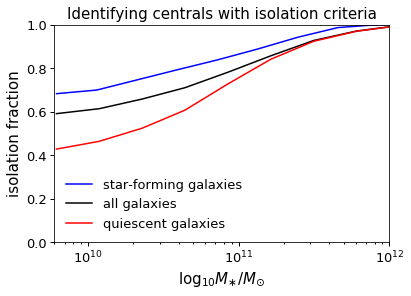

In [12]:
from halotools.mock_observables import mean_y_vs_x
qmask = um_mock['ssfr'] < -11
x_all, y_all, yerr_all = mean_y_vs_x(np.log10(um_mock['sm']), is_iso_all)
x_q, y_q, yerr_q = mean_y_vs_x(np.log10(um_mock['sm'][qmask]), is_iso_all[qmask])
x_a, y_a, yerr_a = mean_y_vs_x(np.log10(um_mock['sm'][~qmask]), is_iso_all[~qmask])

fig, ax = plt.subplots(1, 1)

ax.set_xscale('log')
__=ax.plot(10**x_a, y_a, color='blue', label='star-forming galaxies')
__=ax.plot(10**x_all, y_all, color='k', label='all galaxies')
__=ax.plot(10**x_q, y_q, color='red', label='quiescent galaxies')

xlim = ax.set_xlim(6e9, 10**12)
ylim = ax.set_ylim(0, 1)

xlabel = ax.set_xlabel(r'$\log_{10} M_{\ast}/M_{\odot}$')
ylabel = ax.set_ylabel(r'isolation fraction')
title = ax.set_title('Identifying centrals with isolation criteria')
legend = ax.legend()

fig.savefig('FIGS/isolation_fraction.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


In [13]:
from halotools.mock_observables import mean_radial_velocity_vs_r

In [14]:
mask = (um_mock['upid'] == -1) & (um_mock['mpeak'] > 10**13.75)
cluster_pos = return_xyz_formatted_array(um_mock['x'], um_mock['y'], um_mock['z'], mask=mask)
cluster_vel = return_xyz_formatted_array(um_mock['vx'], um_mock['vy'], um_mock['vz'], mask=mask)
rbins_absolute = rbins

tracer_mask = (um_mock['sm'] < 10**10.5)
tracer_pos = return_xyz_formatted_array(um_mock['x'], um_mock['y'], um_mock['z'], mask=tracer_mask)
tracer_vel = return_xyz_formatted_array(um_mock['vx'], um_mock['vy'], um_mock['vz'], mask=tracer_mask)

vrad_cluster = mean_radial_velocity_vs_r(cluster_pos, cluster_vel, rbins_absolute=rbins, 
                                 sample2=tracer_pos, velocities2=tracer_vel, 
                                 period=halocat.Lbox)


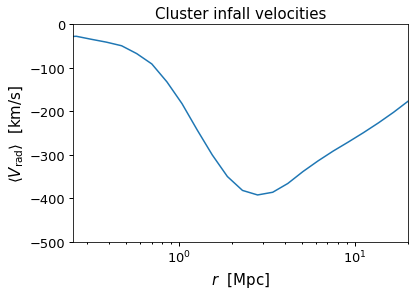

In [15]:
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')

from scipy.signal import savgol_filter

__=ax.plot(rmids, savgol_filter(vrad_cluster, 11, 3))
xlim = ax.set_xlim(0.25, 20)
ylim = ax.set_ylim(-500, 0)

xlabel = ax.set_xlabel(r'$r$  $[{\rm Mpc}]$')
ylabel = ax.set_ylabel(r'$\langle V_{\rm rad}\rangle$  $[{\rm km/s}]$')
title = ax.set_title('Cluster infall velocities')

fig.savefig('FIGS/cluster_infall_velocities.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


In [16]:
halocat = CachedHaloCatalog(simname='bolplanck', redshift=0)
h = halocat.halo_table

In [17]:
cluster_mask = (h['halo_upid'] == -1) & (h['halo_mpeak'] > 10**13.75)
pos_clusters = return_xyz_formatted_array(h['halo_x'], h['halo_y'], h['halo_z'], mask=cluster_mask)
tracer_mask = (h['halo_vpeak'] > 100) & (h['halo_mpeak'] < h['halo_mpeak'][cluster_mask].min())
pos_tracers = return_xyz_formatted_array(h['halo_x'], h['halo_y'], h['halo_z'], mask=tracer_mask)

In [18]:
from halotools.mock_observables import radial_profile_3d
rbins_normalized=np.linspace(0.25, 25, 25)
rmids_normalized=0.5*(rbins_normalized[:-1] + rbins_normalized[1:])
normalize_rbins_by=h['halo_rvir'][cluster_mask]
result = radial_profile_3d(pos_clusters, pos_tracers, h['halo_dmvir_dt_tdyn'][tracer_mask], 
                           rbins_normalized=rbins_normalized, normalize_rbins_by=normalize_rbins_by, 
                           period=250.)

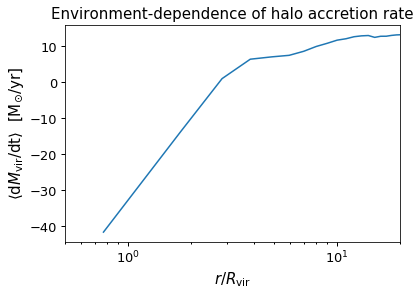

In [19]:
fig, ax = plt.subplots(1, 1)

xscale = ax.set_xscale('log')
__=ax.plot(rmids_normalized, savgol_filter(result, 7, 3))

xlim = ax.set_xlim(0.5, 20)

ylabel = ax.set_ylabel(r'$\langle {\rm d}M_{\rm vir}/{\rm dt} \rangle$  $[{\rm M_{\odot}/yr}]$')
xlabel = ax.set_xlabel(r'$r / R_{\rm vir}$')
title = ax.set_title(r'Environment-dependence of halo accretion rate')

fig.savefig('FIGS/accretion_rate_environment.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')
